In [1]:
import io
from PIL import Image
from skimage.viewer import CollectionViewer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline

Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.


# Градиентный спуск "сделай сам"

В данном задании вам предлагается реализовать и применить метод градиентного спуска для минимизации функции потерь в задаче линейной регресси на искусственных данных. 

Рассматривается одномерная задача регрессии, для решения которой будет использоваться линейная модель:

$$\hat y(x) = w_0 + w_1 x,$$ где $w_0$ и $w_1$ - параметры модели, которые требуется настроить для минимизации среднеквадратичной ошибке по выборке:

$$
    L(w_0, w_1) = \frac{1}{N} \sum\limits_{i=1}^{N} (w_0 + w_1 x_i - y_i)^2 \rightarrow \min\limits_{w_0, w_1}
$$
Для вычисления компонент вектора градиента $g = (g_0, g_1)$ функции $L$ можно использовать следующие формулы:

$$
    g_0 = \frac{2}{N} \sum\limits_{i=1}^{N} (w_0 + w_1 x_i - y_i)      
$$

$$
    g_1 = \frac{2}{N} \sum\limits_{i=1}^{N} x_i (w_0 + w_1 x_i - y_i)      
$$


### Генерация искусственных данных

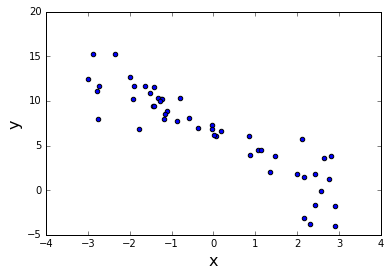

In [50]:
def f(X):
    lin_noise = np.random.normal(0.0, 1.0, size=X.shape[0])
    const_noise = np.random.normal(0.0, 0.5, size=X.shape[0])
                        
    return -(2.3 + lin_noise) * X + 7 + const_noise

N = 50
X = np.hstack(np.random.uniform(-3, 3, size=N)[:, None])
y = f(X)

fig = plt.figure()
plt.scatter(X, y)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()

In [6]:
%matplotlib qt
def draw_surface(X, y, gap=10):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    M = np.hstack([np.ones((X.shape[0], 1)), X[:, None]])
    w = np.linalg.solve(np.dot(M.T, M), np.dot(M.T, y))
    lim_0 = [w[0] - gap, w[0] + gap]
    lim_1 = [w[1] - gap, w[1] + gap]
    w0 = np.linspace(lim_0[0], lim_0[1], 40)
    w1 = np.linspace(lim_1[0], lim_1[1], 40)
    xv, yv = np.meshgrid(w0, w1)
    loss = np.mean(np.square(xv[:, :, None] + 
                            yv[:, :, None] * X[None, None, :] - 
                            y[None, None, :]), axis=2)
    
    
    
    ax.plot_surface(xv, yv, loss, rstride=3, cstride=3, cmap='rainbow')    
    ax.grid()
    fig.show()
    
draw_surface(X, y)

### Полезные функции для визуализации

In [46]:
%matplotlib inline
def visualize_trace(X, y, trace, gap=10):
    M = np.hstack([np.ones((X.shape[0], 1)), X[:, None]])
    w = np.linalg.solve(np.dot(M.T, M), np.dot(M.T, y))
    
    lim_0 = [w[0] - gap, w[0] + gap]
    lim_1 = [w[1] - gap, w[1] + gap]
    w0 = np.linspace(lim_0[0], lim_0[1], 40)
    w1 = np.linspace(lim_1[0], lim_1[1], 40)
    xv, yv = np.meshgrid(w0, w1)
    loss = np.mean(np.square(xv[:, :, None] + 
                            yv[:, :, None] * X[None, None, :] - 
                            y[None, None, :]), axis=2)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    lv = np.mean((trace[-1, 0] + trace[-1, 1] * X - y) ** 2)
    plt.suptitle('Gradient descent plot. MSE = %.5f' % lv, fontsize=24)
    
    CP = axes[0].contour(xv, yv, loss, 30, cmap='rainbow')
    axes[0].clabel(CP)
   
    axes[0].set_xlim(lim_0)
    axes[0].set_ylim(lim_1)
    axes[0].set_xlabel('w0', fontsize=16)
    axes[0].set_ylabel('w1', fontsize=16)
    #print(trace.shape)
    axes[0].plot(trace[:, 0], trace[:, 1], 'b-o', linewidth=2)

    
    axes[0].scatter(w[0], w[1], s=50, marker='*', c='r', edgecolor='r')
    

    axes[1].scatter(X, y, s=30)
    cx = np.linspace(-3.5, 3.5, 3)
    axes[1].plot(cx, cx * w[1] + w[0], 'r--')
    axes[1].plot(cx, cx * trace[-1, 1] + trace[-1, 0], 'k-')
    axes[1].set_xlabel('x', fontsize=16)
    axes[1].set_ylabel('y', fontsize=16)
    d = np.max(y) - np.min(y)
    axes[1].set_ylim([np.min(y) - 0.02 * d, np.max(y) + 0.02 * d])
    
    plt.show()

def visualize_trace_step(X, y, trace, ind, gap=10):
    return visualize_trace(X, y, np.reshape(trace[:ind], [ind, 2]), gap=gap)
    
def interactive_visualizer(X, y, trace, gap=10):    
    return interact(lambda step: visualize_trace_step(X, y, trace, step, gap=gap), 
             step=widgets.IntSlider(min=1,max=trace.shape[0],step=1,value=1))

## Задача №1.
### Подзадача 1.1
Реализуйте следующие функции:
* calc_loss(X, y, w). X - вектор значений признака, y - вектор значений целевой переменной, w - np.array, с параметрами линейной модели. Функция возвращает значение MSE модели на выборке при заданном значении параметров w.
* calc_gradient(X, y, w). X - вектор значений признака, y - вектор значений целевой переменной, w - np.array, с параметрами линейной модели. Функция возвращает градиент функции потерь при заданном значении параметров w.
* calc_trace(X, y, w_init, alpha, steps). X - вектор значений признака, y - вектор значений целевой переменной, w - np.array, с начальными параметрами линейной модели, alpha - длина шага градиентого спуска,  steps - количество шагов. Функция возвращает последовательность точек $w_1, w_2, w_3, \dots w_{steps}$, полученных при выполнении шагов градиентного спуска.

In [32]:
def calc_loss(X, y, w):
    return 1.0

def calc_gradient(X, y, w):
    return np.array([1.0, 1.0])

def calc_trace(X, y, w_init, alpha, steps=15):    
    return np.array([[0, 0], [1, 1]])


### Подзадача 1.2
Проведите визуализацию работы реализованного метода, используя код, предоставленный ниже.
Попробуйте запустить метод из разных начальных приближений и при различных значениях длины шага.

Отнормируйте значения признака $X' = \dfrac{X - \mu}{\sigma}$,  где $\mu$ среднее значение признака, $\sigma$ - стандартное отколнение. Проведите визуализацию работы метода на нормализованных данных. Что вы можете сказать о влиянии нормализации признаков на работу метода градиентного спуска.

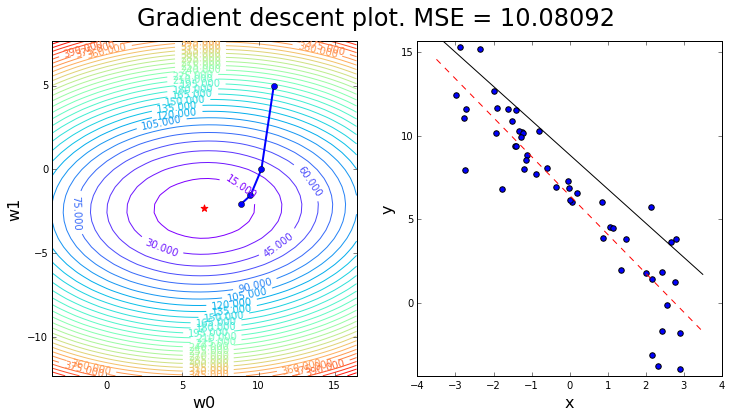

In [52]:
X
trace = calc_trace(X, y, np.array([11, 5]), 0.1, steps=15)
interactive_visualizer(X, y, trace)

### Подзадача 1.3
Найдите минимальное значение функции потерь. Для этого выполните не менее 200 шагов метода. 

### Подзадача 1.4
Отобразите на графике изменение логарифма отклонения значения функции потерь на очередном шаге метода от оптимального значения при увеличении числа шагов. Постройте не менее трех графиков, используя различные длины шагов. Как выбор длины шага влияет на скорость сходимости метода?

Добавьте к построенным графикам, аналогичные кривые, отображающие скорость сходимости метода при использовании нормализованных данных. Сравните скорость сходимости метода при использовании нормализации и без использования. 